In [1]:
from src.operators.radontr import Radontr
#from src.operators.operator import Operator
from src.operators.gradient import Gradient
from src.recon.pwls import PWLS
from src.recon.chambolle_pock import ChambollePock
from src.recon.admm import ADMM
from src.utils.dataloader import ct_test_dataloader, unstandardization
from src.models.unet_diffusion import UNet
from src.losses.data_fidelity import DataFidelity
from src.recon.dps import DeepPosteriorSampling

# from PIL import Image
import torch
import numpy as np
import torch_radon as tr
import matplotlib.pyplot as plt


/home/alex/anaconda3/envs/reconct/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/home/alex/anaconda3/envs/reconct/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


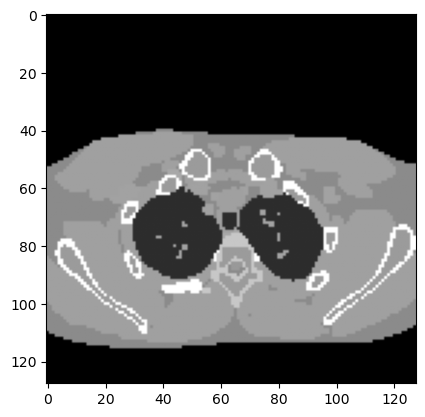

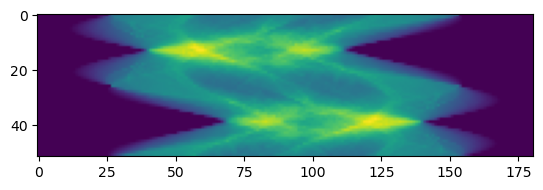

In [2]:

device = 'cuda'

# define projector settings
n_rays = int(np.round(np.sqrt(2)*128))
height, width = 128, 128
n_angles = 52
volume = tr.Volume2D()
volume.set_size(height=height, width=width)
angles = torch.linspace(0, 2 * torch.pi * ((n_angles - 1))/n_angles, n_angles, device=device)

# define projector
radon = Radontr(n_rays=n_rays,
              angles=angles,
              )  # Radon class

# load image
x_true = next(iter(ct_test_dataloader))
# unstandardization, because dataloader throw standardized ct scans
x_true = unstandardization(x_true)

plt.imshow(x_true.squeeze(), cmap='gray')
plt.show() # to avoid overprinting images

# The following is needed to create a Torch object. This requires to add 2 additional dimensions, 1 for batch size, 1 for the number of channels (n,c,d,h,w) (d for depth (not used here in 2D))
x_true = x_true.to(device)   # 0 is the index of the dimension to be added


# generate noisy sinogram
I = 3e5
# EPS = 1e-10
sino = radon.transform(x_true)
y = torch.poisson(I*torch.exp(-sino))
b = torch.zeros_like(y, device=device)
# b = torch.log(I/ (yi))
b[y != 0] = torch.log(I/ (y[y != 0])) 


# print(yi.min())

# shared params
x0 = torch.zeros_like(x_true, device=device)

b_im = b.squeeze().cpu().numpy()
plt.imshow(b_im)
# to avoid overprinting images
plt.show() # to avoid overprinting images
n_iter = 300
n_inner_iter = 100
weights = y
weights[y == 0] = 0

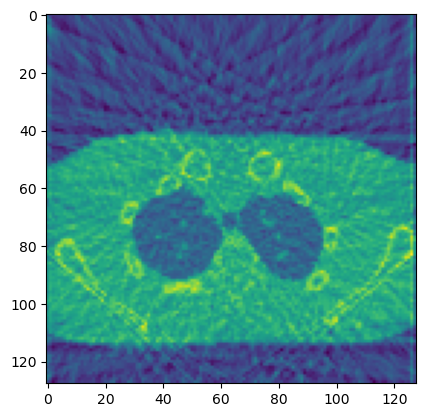

In [3]:
#############################################################################################################################
#                                                           FBP                                                             #
#############################################################################################################################


x_fbp = radon.fbp(b)
plt.show() # to avoid overprinting images
plt.imshow(x_fbp.cpu().squeeze())
plt.imsave('./data/fbp.png', x_fbp.cpu().squeeze(), cmap='gray')

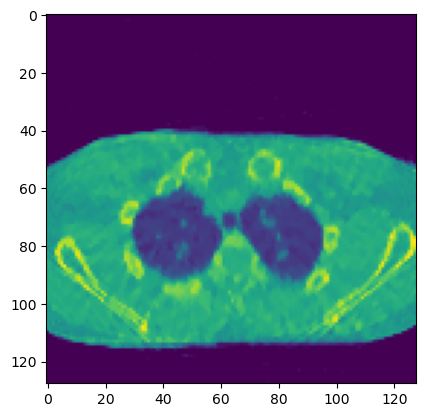

In [9]:
#############################################################################################################################
#                                                           PWLS                                                            #
#############################################################################################################################

sparsifier = Gradient(weight = 'sqrt')
recon = PWLS(systmatrix=radon, sparsifier=sparsifier)

beta = 1e5

x = recon.solve(x0,
                b,
                beta,
                n_iter,
                weights,
                prior = 'huber',
                delta_hub = 0.001
                )

plt.show() # to avoid overprinting images
plt.imshow(x.cpu().squeeze())

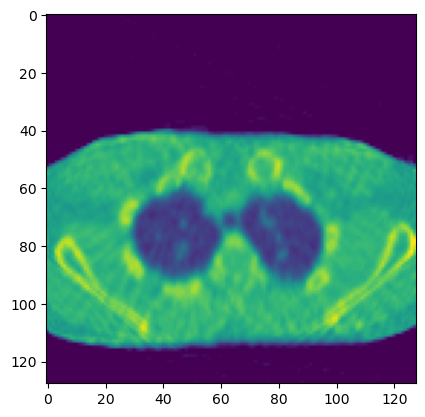

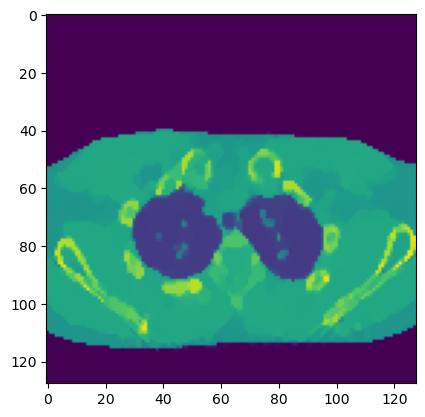

In [11]:
#############################################################################################################################
#                                                           ADMM                                                            #
#############################################################################################################################

sparsifier = Gradient(weight = 'standard')
recon = ADMM(systmatrix=radon, sparsifier=sparsifier)

beta = 3e2
rho = 5000

x = recon.solve(x0,
                 b,
                 beta,
                 rho,
                 n_iter,
                 n_inner_iter,
                 weights)

plt.show() # to avoid overprinting images
plt.imshow(x.cpu().squeeze())

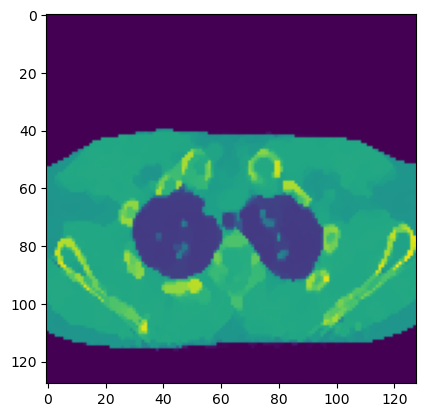

In [13]:
#############################################################################################################################
#                                                      Chambolle Pock                                                       #
#############################################################################################################################




sparsifier = Gradient(weight = 'standard')
recon = ChambollePock(systmatrix=radon, sparsifier=sparsifier)

beta = 3e2
theta = 1
L = sparsifier.norm(height, width)
sigma = 0.99 * (1e8 / (np.sqrt(1e8 * 1) * L))
tau = 0.99 * (1 / (np.sqrt(1e8 * 1) * L))

x = recon.solve( x0,
                    b,
                    beta,
                    tau,
                    sigma,
                    theta,
                    n_iter,
                    n_inner_iter,
                    weights)


plt.show() # to avoid overprinting images
plt.imshow(x.cpu().squeeze())


In [12]:
#############################################################################################################################
#                                                     DPS                                                                   #
#############################################################################################################################

# load pretrained models 
weights_path = './weights/wavelet128x128x128_standardized_diverse_model_epoch_199.pth'
model = UNet(in_chan=1,
             out_chan=1,
             T=1000,
             ch=128,
             ch_mult=[1, 2, 2, 2],
             attn=[1],
             num_res_blocks=2,
             dropout=0.1)
model.load_state_dict(torch.load(weights_path))
model.to(device)



# instantiate data fidelity term
data_fidelity = DataFidelity(forward_operator=radon)

# instanciate dps
dps = DeepPosteriorSampling(model=model,
                            data_fidelity=data_fidelity,
                            device=device)

# sampling
# lam = 10
lam = 0.00000001

xT = torch.randn((1, 1, 128, 128)).to(device)
x0 = dps.inference(xT=xT, 
                    y=b,
                    weights=y,
                    lam=lam)

1000it [02:32,  6.57it/s]


/home/alex/anaconda3/envs/reconct/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


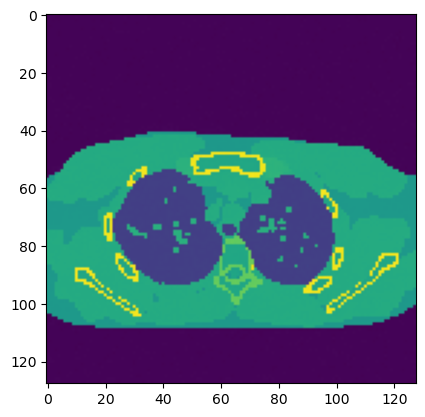

In [13]:
plt.imshow(x0.cpu().squeeze())
plt.show() # to avoid overprinting images

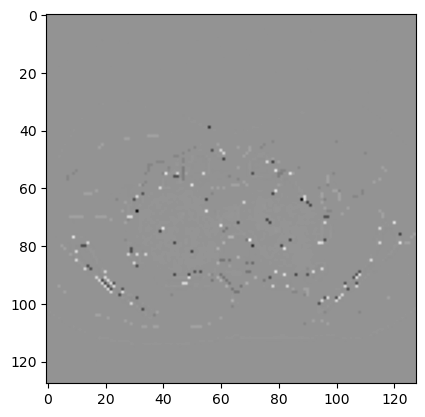

In [ ]:
# Display difference with ground truth
plt.imshow((x0 - x_true).cpu().squeeze(),cmap='gray')
plt.show() # to avoid overprinting images
